# 超參數配置

In [1]:
# 前處理參數
seq_len = 5  # 序列長度(查看過去之天數)  5
train_size = 0.8  # 分割資料比例
df_check_out_loc = './data/sum_check_out.xlsx'  # 設定資料路徑
df_inventory_loc = './data/inventory.xlsx'
df_put_in_loc = './data/sum_put_in.xlsx'
item = 'A'  # 抓取之品項
predict_week = 2  # 預測未來N週

# 模型參數
model_name = 'LSTM'  # SimpleRNN, LSTM, GRU可使用
input_size = 1  # 餵入的特徵種數
hidden_size = 5  # model隱藏層   5
num_layers = 1  # model層數
epoch = 3000  # 訓練回合數 LSTM   3000
#epoch = 5000  # 訓練回合數 GRU
lr = 0.001  # 學習率
val_mathod = 'MSE'  # MSE、MAE、R2可使用

# 載入必要之函式庫

In [2]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import math

# sklearn評估指標
from sklearn.metrics import mean_absolute_error  # MAE
from sklearn.metrics import mean_squared_error  #MSE
from math import sqrt  # RMSE: sqrt( MAE )
from sklearn.metrics import r2_score  #R2

In [3]:
# 使用GPU訓練
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# 方便研究用
np.random.seed(15)
torch.manual_seed(15)

# 資料前處理

## 讀取原始資料

In [5]:
df = pd.read_excel(df_check_out_loc)
#df = df.T  # 資料旋轉
df

,Year,week,A,B,C,D
0,2020.0,13,1170,710,1905,1590
1,NaN,14,0,0,635,530
2,NaN,15,1205,318,2340,1680
3,NaN,16,955,715,2775,1060
4,NaN,17,610,985,1270,1940
...,...,...,...,...,...,...
88,NaN,48,1379,600,1279,0
89,NaN,49,440,1294,1142,2104
90,NaN,50,0,0,878,0
91,NaN,51,600,44,3728,2012


## 修正資料格式

In [6]:
#  填補年份NaN值
df['Year'] = df['Year'].fillna(method='ffill',axis=0)
df

,Year,week,A,B,C,D
0,2020.0,13,1170,710,1905,1590
1,2020.0,14,0,0,635,530
2,2020.0,15,1205,318,2340,1680
3,2020.0,16,955,715,2775,1060
4,2020.0,17,610,985,1270,1940
...,...,...,...,...,...,...
88,2021.0,48,1379,600,1279,0
89,2021.0,49,440,1294,1142,2104
90,2021.0,50,0,0,878,0
91,2021.0,51,600,44,3728,2012


In [7]:
print("[before type]\n", df.dtypes)
df = df.astype('int64')  # 全部轉int64
print("\n[after type]:\n", df.dtypes)

[before type]
 Year    float64
week      int64
A         int64
B         int64
C         int64
D         int64
dtype: object

[after type]:
 Year    int64
week    int64
A       int64
B       int64
C       int64
D       int64
dtype: object


In [8]:
df = df.set_index(['Year','week'])  # 將某欄位換成索引名稱(Date欄位->index)，原本Date欄位消失
df

A     B     C     D
Year week                        
2020 13    1170   710  1905  1590
     14       0     0   635   530
     15    1205   318  2340  1680
     16     955   715  2775  1060
     17     610   985  1270  1940
...         ...   ...   ...   ...
2021 48    1379   600  1279     0
     49     440  1294  1142  2104
     50       0     0   878     0
     51     600    44  3728  2012
     52      58   360   552  1042

[93 rows x 4 columns]

In [9]:
# 去除null空值
null_num = df.isnull().sum().sum()  # 求null個數
print("[before]\nnull_number=", null_num)
df = df.dropna()  # 去除null

null_num = df.isnull().sum().sum()  # 求null個數
print("\n[after]\nnull_number=", null_num)

print("\nData Total Series:",len(df))

[before]
null_number= 0

[after]
null_number= 0

Data Total Series: 93


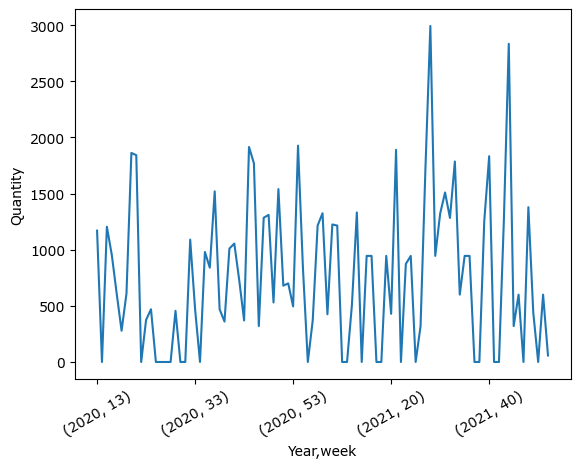

In [10]:
df[item].plot()  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

In [11]:
# []:只能單列； [[]]:可以多列
df = df[[item]].astype('float32')  # 轉成float [model餵入data需要的格式]
df

A
Year week        
2020 13    1170.0
     14       0.0
     15    1205.0
     16     955.0
     17     610.0
...           ...
2021 48    1379.0
     49     440.0
     50       0.0
     51     600.0
     52      58.0

[93 rows x 1 columns]

In [12]:
dataset = df[[item]].values  # 轉成一維，形成dataset
print(type(dataset))
print("dataset:", dataset.shape)
print(dataset[0:5])

<class 'numpy.ndarray'>
dataset: (93, 1)
[[1170.]
 [   0.]
 [1205.]
 [ 955.]
 [ 610.]]


## 資料正規化

In [13]:
scaler = MinMaxScaler()  # 選擇計算類型
ori_dataset = dataset
dataset = scaler.fit_transform(dataset)  # Normalization 歸一化0~1數值

print("正規化:")
for i in range(20):  # 察看結果用
    print(ori_dataset[i]," -> ",dataset[i])

正規化:
[1170.]  ->  [0.39091215]
[0.]  ->  [0.]
[1205.]  ->  [0.4026061]
[955.]  ->  [0.31907785]
[610.]  ->  [0.20380889]
[278.]  ->  [0.09288339]
[610.]  ->  [0.20380889]
[1862.]  ->  [0.6221183]
[1842.]  ->  [0.615436]
[0.]  ->  [0.]
[375.]  ->  [0.12529235]
[470.]  ->  [0.15703309]
[0.]  ->  [0.]
[0.]  ->  [0.]
[0.]  ->  [0.]
[0.]  ->  [0.]
[456.]  ->  [0.15235549]
[0.]  ->  [0.]
[0.]  ->  [0.]
[1090.]  ->  [0.3641831]


## 切割Train, Val資料

In [14]:
#將資料集分成 訓練集、測試集
def split_data(data, train_size):
    train_size = int(dataset.shape[0] * train_size)
    test_size = dataset.shape[0] - train_size
    print("全部:", len(dataset), "筆 \n\n訓練資料:", train_size,"筆 \n測試資料:", test_size,"筆")
    train_data = dataset[:train_size]
    
    test_data = dataset[(train_size-seq_len):]  # 第一筆test_data即為Y，故要包含前面seq_len筆資料
    print("\nTrain_data",train_data.shape)
    print("Test_data",test_data.shape)
    print("\n內容值預覽:\n", train_data[20:25])
    return train_data, test_data

train_data, test_data = split_data(dataset, train_size)

全部: 93 筆 

訓練資料: 74 筆 
測試資料: 19 筆

Train_data (74, 1)
Test_data (24, 1)

內容值預覽:
 [[0.15703309]
 [0.        ]
 [0.32743067]
 [0.28065488]
 [0.50785166]]


## 調整餵入模型之序列資料

In [15]:
# 生成過去seq_len天(X)+當天(Y)； Y=ground true
def create_seq(data, seq_len):
    print("[before]\n", data.shape)
    x = []
    y = []
    for i in range(len(data)-seq_len):  # 不需多減1
        #print("有",i+1,"組")
        _x = data[i:(i+seq_len)]  # 0,1,2...(seq_len-1)
        _y = data[(i+seq_len)]  # seq_len
        x.append(_x)
        y.append(_y)
    x = torch.as_tensor(np.array(x))  # 轉成 numpy(速度較快) -> tensor
    y = torch.as_tensor(np.array(y))
    print("[after input]\n", x.shape,"\n")
    return x, y

train_x, train_y = create_seq(train_data, seq_len)
test_x, test_y = create_seq(test_data, seq_len)
val_x, val_y = create_seq(test_data, seq_len)

[before]
 (74, 1)
[after input]
 torch.Size([69, 5, 1]) 

[before]
 (24, 1)
[after input]
 torch.Size([19, 5, 1]) 

[before]
 (24, 1)
[after input]
 torch.Size([19, 5, 1]) 



# 建立模型

## 參數解釋

- Pytorch裡的LSTM單元接受的輸入都必須是3維的張量(Tensors).每一維代表的意思不能弄錯。
- 第一維(i)體現的是序列（sequence）結構,也就是序列的個數，用文章來說，就是每個句子的長度，因為是餵給網絡模型，一般都設定為確定的長度，也就是我們餵給LSTM神經元的每個句子的長度，當然，如果是其他的帶有帶有序列形式的數據，則表示一個明確分割單位長度。
- 第二維(j)度體現的是batch_size，也就是一次性餵給網絡多少條句子，或者股票數據中的，一次性餵給模型多少個時間單位的數據，具體到每個時刻，也就是一次性餵給特定時刻處理的單元的單詞數或者該時刻應該餵給的股票數據的條數。
- 第三維(k)體現的是輸入的元素（elements of input），也就是，每個具體的單詞用多少維向量來表示，或者股票數據中每一個具體的時刻的採集多少具體的值，比如最低價、最高價、均價、5日均價、10均價，則k=5，等等。
- H0-Hn是什麼意思呢？就是每個時刻中間神經元應該保存的這一時刻的根據輸入和上一課的時候的中間狀態值應該產生的本時刻的狀態值，這個數據單元是起的作用就是記錄這一時刻之前考慮到所有之前輸入的狀態值，形狀應該是和特定時刻的輸出一致。
- c0-cn就是開關，決定每個神經元的隱藏狀態值是否會影響的下一時刻的神經元的處理，形狀應該和h0-hn一致。
- 當然如果是雙向，和多隱藏層還應該考慮方向和隱藏層的層數。
- lstm的輸出會有 output和最後一個CELL的 hidden state, cell state，在pytorch裏頭，output的值其實就是每個cell的hidden state集合起來的陣列。

## Model

In [16]:
# LSTM Model
class LSTM(nn.Module): # Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, seq_len, hidden_size, num_layers):
        super().__init__()
        # 外部()參數導入
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.rnn = nn.LSTM(
            input_size = input_size,  # 餵入的特徵種數 (ex:預測訂單量, input_szie=1)
            hidden_size = hidden_size,  # hidden state(h)的feature numbers
            num_layers = num_layers,
            batch_first = True  # Default:(seq_len, batch_size, input_size)； True:(batch_size, seq_len, input_size)
        )
        self.fc = nn.Linear(self.hidden_size, 1)  # 串接:(hidden_size) -> (1)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # h,c:(num_layers * num_directions, batch_size, hidden_size)     
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)    
        model_out, (h_n, c_n) = self.rnn(x, (h_0, c_0))
        
        # model_out:(batch_size, seq_len, hidden_size)
        fc_in = model_out[:,-1,:]  # 抓取每組的最後一個seq_len
        # fc_in:(batch_size, hidden_size)
        fc_out = self.fc(fc_in)  # 全連接層
        # fc_out:(batch_size, 1)
        return fc_out    
# 呼叫方法
#model = LSTM(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU

In [17]:
# GRU Model
class GRU(nn.Module): # Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, seq_len, hidden_size, num_layers):
        super().__init__()
        # 外部()參數導入
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.rnn = nn.GRU(
            input_size = input_size,  # 餵入的特徵種數 (ex:預測訂單量, input_szie=1)
            hidden_size = hidden_size,  # hidden state(h)的feature numbers
            num_layers = num_layers,
            batch_first = True  # Default:(seq_len, batch_size, hidden_size)； True:(batch_size, seq_len, hidden_size)
        )
        self.fc = nn.Linear(self.hidden_size, 1)  # 串接:(hidden_size) -> (1)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # h,c:(num_layers * num_directions, batch_size, hidden_size)     
        model_out, (h_n) = self.rnn(x, (h_0))
        
        # model_out:(batch_size, seq_len, hidden_size)
        fc_in = model_out[:,-1,:]  # 抓取每組的最後一個seq_len
        # fc_in:(batch_size, hidden_size)
        fc_out = self.fc(fc_in)  # 全連接層
        # fc_out:(batch_size, 1)
        return fc_out    
# 呼叫方法
#model = GRU(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU

In [18]:
# SimpleRNN Model
class SimpleRNN(nn.Module): # Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, seq_len, hidden_size, num_layers):
        super().__init__()
        # 外部()參數導入
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(
            input_size = input_size,  # 餵入的特徵種數 (ex:預測訂單量, input_szie=1)
            hidden_size = hidden_size,  # hidden state(h)的feature numbers
            num_layers = num_layers,
            batch_first = True  # Default:(seq_len, batch_size, hidden_size)； True:(batch_size, seq_len, hidden_size)
        )
        self.fc = nn.Linear(self.hidden_size, 1)  # 串接:(hidden_size) -> (1)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # h,c:(num_layers * num_directions, batch_size, hidden_size)     
        model_out, (h_n) = self.rnn(x, (h_0))
        
        # model_out:(batch_size, seq_len, hidden_size)
        fc_in = model_out[:,-1,:]  # 抓取每組的最後一個seq_len
        # fc_in:(batch_size, hidden_size)
        fc_out = self.fc(fc_in)  # 全連接層
        # fc_out:(batch_size, 1)
        return fc_out    
# 呼叫方法
#model = SimpleRNN(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU

In [19]:
if model_name == 'LSTM':
    model = LSTM(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU
if model_name == 'GRU':
    model = GRU(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU
if model_name == 'SimpleRNN':
    model = SimpleRNN(seq_len, hidden_size, num_layers).to(device)  # 餵入的train_x也要一致換成GPU

## 查看模型Shape

In [20]:
def look_model_shape(seq_len, hidden_size, num_layers, device):
    if model_name == 'LSTM':
        model = LSTM(seq_len, hidden_size, num_layers).to(device)
    if model_name == 'GRU':
        model = GRU(seq_len, hidden_size, num_layers).to(device)
    if model_name == 'SimpleRNN':
        model = SimpleRNN(seq_len, hidden_size, num_layers).to(device)
    print("查看模型結構:\n",model)
    print("\n查看網路參數:")
    for name, parameters in model.named_parameters():
        print(name, ':', parameters.size())
        
look_model_shape(seq_len, hidden_size, num_layers, device)

查看模型結構:
 LSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

查看網路參數:
rnn.weight_ih_l0 : torch.Size([20, 1])
rnn.weight_hh_l0 : torch.Size([20, 5])
rnn.bias_ih_l0 : torch.Size([20])
rnn.bias_hh_l0 : torch.Size([20])
fc.weight : torch.Size([1, 5])
fc.bias : torch.Size([1])


# 訓練模型

In [21]:
def train(train_x, train_y, val_x, val_y, Epoch, lr):
    loss_fn = torch.nn.MSELoss(reduction='mean')  # 設定loss, default='mean'
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=0.000001)  # 設定optimization
    model.train()  # 開啟訓練模式
    
    if val_mathod == 'R2': 
        Best_val_Score = -10
    else: Best_val_Score = 1
        
    # 保存loss歷史數據，plt看圖用
    train_loss_list = np.zeros(Epoch)
    val_loss_list = np.zeros(Epoch)
    
    Best_Epoch = 0
    for epoch in range(Epoch):
        # 資料移動到GPU計算
        train_x, train_y = train_x.to(device), train_y.to(device)
        # 優化器清空(Reset Gradient)
        optimizer.zero_grad()  
        # 餵入模型
        output = model(train_x)
        if epoch <=0: print("模型output shape:", output.shape)
            
        # 計算loss值
        loss = loss_fn(output, train_y)
        loss.backward()  # 反向傳播->計算當前Gradient
        optimizer.step()  # 更新Gradient，根據Gradient Descent更新網路參數
        train_loss_list[epoch] = loss.item()  # 保存loss
        
        #-------------------評估最佳模型-----------------
        with torch.no_grad():  # val_x, val_y
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_pred = model(val_x)
            loss_val = loss_fn(val_pred, val_y)
            val_loss_list[epoch] = loss_val
            
            if val_mathod == 'MSE':
                val_Score = mean_squared_error(val_y.cpu().detach().numpy(), val_pred.cpu().detach().numpy())
                if Best_val_Score > val_Score:
                    Best_val_Score = val_Score
                    Best_Epoch = epoch
                    torch.save(model, 'Best_Model.pth')  # 保存評估後最佳模型
            if val_mathod == 'MAE':
                val_Score = mean_absolute_error(val_y.cpu().detach().numpy(), val_pred.cpu().detach().numpy())
                if Best_val_Score > val_Score:
                    Best_val_Score = val_Score
                    Best_Epoch = epoch
                    torch.save(model, 'Best_Model.pth')  # 保存評估後最佳模型
            if val_mathod == 'R2':   
                val_Score = r2_score(val_y.cpu().detach().numpy(), val_pred.cpu().detach().numpy())
                if Best_val_Score < val_Score:
                    Best_val_Score = val_Score
                    Best_Epoch = epoch
                    torch.save(model, 'Best_Model.pth')  # 保存評估後最佳模型
        
        if (epoch+1) % 300 == 0:
            print(f'Epoch: {epoch}, train_loss: {loss.item():.5f}')
            torch.save(model, 'Last_Model.pth')
        if epoch == Epoch-1:
            print(f'\nEpoch -> {Best_Epoch}, Best_Model_Score({val_mathod}) test_loss: {Best_val_Score:.5f}')
    return train_loss_list, val_loss_list
# 呼叫方法
train_loss_list, val_loss_list = train(train_x, train_y, val_x, val_y, epoch, lr)

模型output shape: torch.Size([69, 1])
Epoch: 299, train_loss: 0.04615
Epoch: 599, train_loss: 0.04583
Epoch: 899, train_loss: 0.04435
Epoch: 1199, train_loss: 0.04247
Epoch: 1499, train_loss: 0.03880
Epoch: 1799, train_loss: 0.02798
Epoch: 2099, train_loss: 0.02081
Epoch: 2399, train_loss: 0.01360
Epoch: 2699, train_loss: 0.00473
Epoch: 2999, train_loss: 0.00222

Epoch -> 1422, Best_Model_Score(MSE) test_loss: 0.05466


# 評估模型

In [22]:
model.eval()
# 取得model預測值
train_pred = model(train_x.to(device)).cpu().detach().numpy()
test_pred = model(test_x.to(device)).cpu().detach().numpy()

print("model output shape:", train_pred.shape)

model output shape: (69, 1)


In [23]:
# 還原常態化 "預測值"
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# 還原常態化 "Ground True值"
dataset = scaler.inverse_transform(dataset)  # 原始資料
train_gt = scaler.inverse_transform(train_y)  # train ground true
test_gt = scaler.inverse_transform(test_y)  # test ground true

# 還原後，四捨五入、float -> int
dataset = np.add(dataset, 0.5).astype('int')
train_pred = np.add(train_pred, 0.5).astype('int')
test_pred = np.add(test_pred, 0.5).astype('int')
train_gt = np.add(train_gt, 0.5).astype('int')
test_gt = np.add(test_gt, 0.5).astype('int')

"""
# 轉成一維 (98,1)->(1,98)  或  (98,)->(98,1)
train_pred = train_pred.reshape(1,-1)
test_pred = test_pred.reshape(1,-1)
train_gt = train_gt.reshape(1,-1)
test_gt = test_gt.reshape(1,-1)
"""

'\n# 轉成一維 (98,1)->(1,98)  或  (98,)->(98,1)\ntrain_pred = train_pred.reshape(1,-1)\ntest_pred = test_pred.reshape(1,-1)\ntrain_gt = train_gt.reshape(1,-1)\ntest_gt = test_gt.reshape(1,-1)\n'

In [24]:
# 轉換shape
train_pred_to_excel = train_pred.reshape(1,-1)
train_gt_to_excel = train_gt.reshape(1,-1)

test_pred_to_excel = test_pred.reshape(1,-1)
test_gt_to_excel = test_gt.reshape(1,-1)

In [25]:
# 匯出資料集的正確值和預測值
a = pd.DataFrame(train_gt_to_excel)
b = pd.DataFrame(train_pred_to_excel)

Train_Result_to_excel = pd.DataFrame()
Train_Result_to_excel = Train_Result_to_excel.append(a, ignore_index=True)
Train_Result_to_excel = Train_Result_to_excel.append(b, ignore_index=True)
to_excel_name = {0:"gt", 1:"pred"}
Train_Result_to_excel.rename(index = to_excel_name, inplace=True)

Train_Result_to_excel

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
gt,278,610,1862,1842,0,375,470,0,0,0,...,945,0,318,1728,2993,945,1322,1510,1283,1786
pred,266,877,1917,1972,72,554,508,-9,-38,213,...,960,-28,313,1474,2879,725,1343,1311,1320,2049


In [26]:
a = pd.DataFrame(test_gt_to_excel)
b = pd.DataFrame(test_pred_to_excel)

Test_Result_to_excel = pd.DataFrame()
Test_Result_to_excel = Test_Result_to_excel.append(a, ignore_index=True)
Test_Result_to_excel = Test_Result_to_excel.append(b, ignore_index=True)
to_excel_name = {0:"Test_gt", 1:"Test_pred"}
Test_Result_to_excel.rename(index = to_excel_name, inplace=True)

Test_Result_to_excel

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Test_gt,600,945,945,0,0,1257,1833,0,0,1265,2834,320,600,0,1379,440,0,600,58
Test_pred,455,1645,791,1387,133,481,945,613,1051,1516,2673,1870,539,297,-582,-1648,1292,423,1276


# 驗證成效 (Last Model)

## 前處理shape

In [27]:
# 查看畫圖時shape是否一致
print("原始資料(前/後) -> ", df.index.values.shape, " ", dataset.shape)
print("Train資料(前/後) -> ",train_pred.shape, " ", df.index.values[seq_len : train_pred.shape[0]+seq_len].shape)
print("Test資料(前/後) ->  ",test_pred.shape, " ", df.index.values[test_pred.shape[0]+seq_len : ].shape)

原始資料(前/後) ->  (93,)   (93, 1)
Train資料(前/後) ->  (69, 1)   (69,)
Test資料(前/後) ->   (19, 1)   (69,)


In [28]:
date = []
for i in range(len(df)):
    date.append(df.index[i][1])
date = np.array(date)
date = date.reshape(-1,1)

In [29]:
df = df.reset_index()
df

,Year,week,A
0,2020,13,1170.0
1,2020,14,0.0
2,2020,15,1205.0
3,2020,16,955.0
4,2020,17,610.0
...,...,...,...
88,2021,48,1379.0
89,2021,49,440.0
90,2021,50,0.0
91,2021,51,600.0


In [30]:
# index = Year_week (合併年/週)
index_num = df['Year'].astype('str') + '_' + df['week'].astype('str') 
index_num

0     2020_13
1     2020_14
2     2020_15
3     2020_16
4     2020_17
       ...   
88    2021_48
89    2021_49
90    2021_50
91    2021_51
92    2021_52
Length: 93, dtype: object

## 加載訓練好模型

In [31]:
# 讀取模型和處理好之data(為方便獨立驗證，已拉出一份excel檔)
# 要預測的變數
df_inventory = pd.read_excel(df_inventory_loc)  
df_check_out = pd.read_excel(df_check_out_loc)  # input
df_put_in = pd.read_excel(df_put_in_loc)

# 選擇模型
best_model = torch.load('Last_Model.pth')  
best_model.eval()

# 使用GPU訓練
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# 模型使用GPU
best_model.to(device)

LSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

## 求出預測輸出

In [32]:
df_inventory['Year'] = df_inventory['Year'].fillna(method='ffill',axis=0)  # 填滿缺值
df_check_out['Year'] = df_check_out['Year'].fillna(method='ffill',axis=0)  # 填滿缺值
df_put_in['Year'] = df_put_in['Year'].fillna(method='ffill', axis=0)  # 填滿缺值
# 合併DataFrame (取聯集=outer, 交集=inner)
df_merge = pd.merge(df_put_in, df_check_out, on=['Year','week'], how='outer', suffixes=('_put_in', '_check_out'))
df_merge = df_merge.fillna(0)
# 求出"真實庫存量"
name_inventory = item
df_inventory = df_inventory[name_inventory]
inventory_gt = np.array(df_inventory).reshape(-1, 1)
# 求出"真實入庫量"
name_put_in = item + '_put_in'
put_in_gt = df_merge[name_put_in]
put_in_gt = np.array(put_in_gt).reshape(-1, 1)
put_in_gt = put_in_gt[seq_len:]  # 從第seq_len筆資料開始(預測的第一天開始)
# 求出"真實出庫量"
name_check_out = item + '_check_out'
check_out_gt = df_merge[name_check_out]
check_out_gt = np.array(check_out_gt).reshape(-1, 1)
# 求出測資料之"日期"
get_date = pd.DataFrame()
get_date['Year'] = df_merge['Year']
get_date['week'] = df_merge['week']
get_date = get_date.astype('int64')
get_date = get_date
# 正規化
scaler = MinMaxScaler()  # 選擇計算類型
df_check_out = check_out_gt
df_check_out = scaler.fit_transform(df_check_out)  # Normalization 歸一化0~1數值

print("正規化:")
for i in range(10):  # 察看結果用
    print(check_out_gt[i]," -> ",df_check_out[i])
    
# 生成過去seq_len天(X)+當天(Y)； Y=ground true
def create_seq(data, seq_len):
    print("時序資料轉換:\n")
    print("[before]\n", data.shape)
    x = []
    y = []
    for i in range(len(data)-seq_len):  # 不需多減1
        #print("有",i+1,"組")
        _x = data[i:(i+seq_len)]  # 0,1,2...(seq_len-1)
        _y = data[(i+seq_len)]  # seq_len
        x.append(_x)
        y.append(_y)
    x = torch.as_tensor(np.array(x))  # 轉成 numpy(速度較快) -> tensor
    y = torch.as_tensor(np.array(y))
    print("\n[after input]\n", x.shape,"\n")
    return x, y

test_x, test_y = create_seq(df_check_out, seq_len)
test_x = test_x.float()
test_y = test_y.float()

test_pred = best_model(test_x.to(device)).cpu().detach().numpy()  # 必須餵入tensor('float32')格式的data
print("model output shape:", test_pred.shape)

# 還原常態化 "預測值"
test_pred = scaler.inverse_transform(test_pred)

# 還原常態化 "Ground True值"
dataset = scaler.inverse_transform(df_check_out)  # 原始資料
test_gt = scaler.inverse_transform(test_y)  # test ground true

# 還原後，四捨五入、float -> int
dataset = np.add(dataset, 0.5).astype('int')
test_pred = np.add(test_pred, 0.5).astype('int')
test_gt = np.add(test_gt, 0.5).astype('int')

# 入庫不能為負值
test_pred[test_pred<0] = 0

# 求出"預測庫存量"
inventory_pred = test_pred - test_gt  # 入庫-出庫
inventory_pred[0] = inventory_gt[seq_len-1] + inventory_pred[0]  # 加上初始庫存量(根據seq_len改動)
inventory_pred = np.cumsum(inventory_pred).reshape(-1, 1)  # 做加總


正規化:
[1170]  ->  [0.39091213]
[0]  ->  [0.]
[1205]  ->  [0.40260608]
[955]  ->  [0.31907785]
[610]  ->  [0.20380889]
[278]  ->  [0.09288339]
[610]  ->  [0.20380889]
[1862]  ->  [0.62211828]
[1842]  ->  [0.61543602]
[0]  ->  [0.]
時序資料轉換:

[before]
 (93, 1)

[after input]
 torch.Size([88, 5, 1]) 

model output shape: (88, 1)


In [33]:
# 確認資料型態
print("get_date:", get_date.shape)

print("\ncheck_out_gt:", check_out_gt.shape)
print(check_out_gt[0:5])

print("\ntest_pred:", test_pred.shape)
print(test_pred[0:5])

print("\ntest_gt:", test_gt.shape)
print(test_gt[0:5])

print("\nput_in_gt:", put_in_gt.shape)
print(put_in_gt[0:5])

print("\ninventory_gt:", inventory_gt.shape)
print(inventory_gt[0:5])

print("\ninventory_pred:", inventory_pred.shape)
print(inventory_pred[0:5])

get_date: (93, 2)

check_out_gt: (93, 1)
[[1170]
 [   0]
 [1205]
 [ 955]
 [ 610]]

test_pred: (88, 1)
[[ 264]
 [ 875]
 [1915]
 [1967]
 [  72]]

test_gt: (88, 1)
[[ 278]
 [ 610]
 [1862]
 [1842]
 [   0]]

put_in_gt: (88, 1)
[[1000]
 [1000]
 [1000]
 [1250]
 [1250]]

inventory_gt: (93, 1)
[[  0]
 [  0]
 [  0]
 [ 45]
 [435]]

inventory_pred: (88, 1)
[[421]
 [686]
 [739]
 [864]
 [936]]


### 測試用-查看內容值

In [34]:
# 測試用
test = pd.DataFrame()
index_num_y = index_num[seq_len:]  # 日期從預測的第一週開始
index_num_y.reset_index(drop=True, inplace=True)

test['Year_Week'] = index_num_y
test['test_pred'] = pd.DataFrame(test_pred)
test['test_gt'] = pd.DataFrame(test_gt)
test['div'] = pd.DataFrame(test_pred - test_gt)
test['cumsum'] = pd.DataFrame(inventory_pred)
test['inventory_gt'] = pd.DataFrame(inventory_gt[seq_len:])
test.to_excel('./data/test.xlsx', sheet_name='check_quantity', index=True)
test

,Year_Week,test_pred,test_gt,div,cumsum,inventory_gt
0,2020_18,264,278,-14,421,1157
1,2020_19,875,610,265,686,1547
2,2020_20,1915,1862,53,739,685
3,2020_21,1967,1842,125,864,93
4,2020_22,72,0,72,936,1343
...,...,...,...,...,...,...
83,2021_48,0,1379,-1379,3199,3922
84,2021_49,0,440,-440,2759,4482
85,2021_50,1292,0,1292,4051,5982
86,2021_51,423,600,-177,3874,6282


## 可視化-出庫量結果

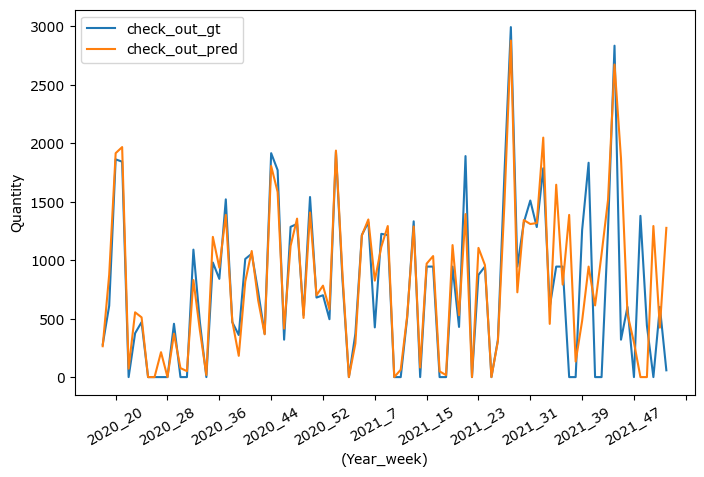

In [35]:
# 可視化結果-出庫量
index_num = get_date['Year'].astype('str') + '_' + get_date['week'].astype('str')  # index_num = Year_week (合併年/週)

plt.figure(figsize = (8,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))  # 設定x軸刻度間距 
plt.plot( index_num[seq_len:] , test_gt, label='check_out_gt')
plt.plot( index_num[seq_len:] , test_pred, label='check_out_pred')

plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()
plt.show()

## 可視化-庫存量結果

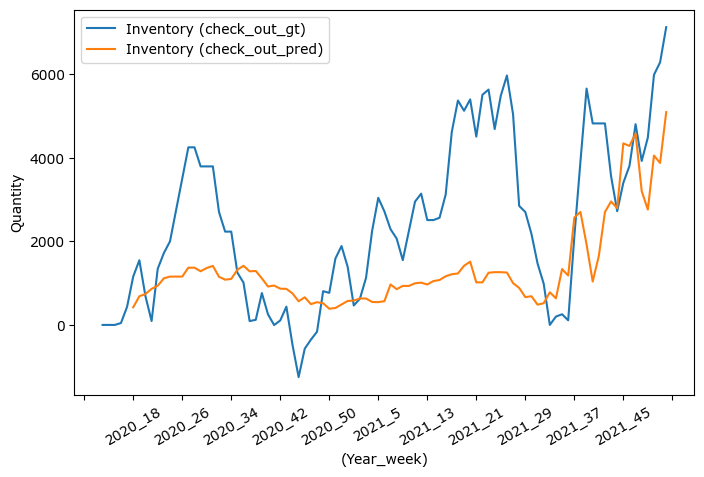

In [36]:
# 可視化結果-比較庫存量
index_num = get_date['Year'].astype('str') + '_' + get_date['week'].astype('str')  # index_num = Year_week (合併年/週)

plt_inventory = plt.figure(figsize = (8,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))  # 設定x軸刻度間距 
plt.plot( index_num , inventory_gt, label='Inventory (check_out_gt)')
plt.plot( index_num[seq_len:] , inventory_pred, label='Inventory (check_out_pred)')


plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()

plt.savefig('./data/在庫量改善成果.png') 
plt.show()

## 可視化-指定某區間結果

In [37]:
#index_num[50:80]  # 查看對應區間 [tart_day:nd_day]

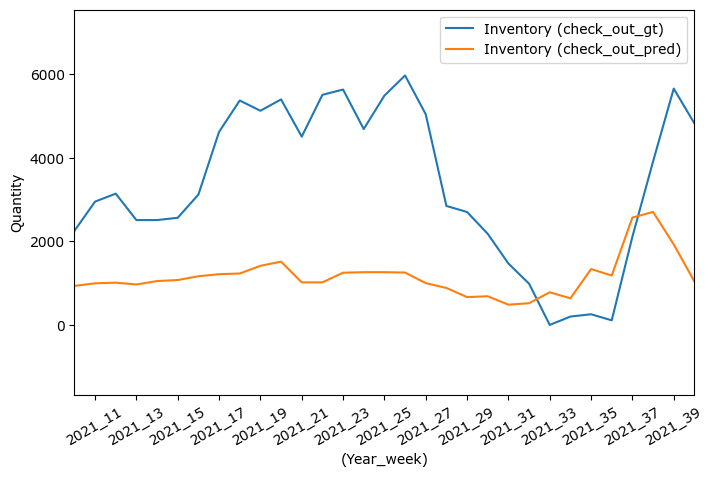

In [38]:
# 選擇想查看的區間(根據上面號碼)
start_day = 50
end_day = 80

plt.figure(figsize = (8,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

plt.plot( index_num , inventory_gt, label='Inventory (check_out_gt)')
plt.plot( index_num[seq_len:] , inventory_pred, label='Inventory (check_out_pred)')

# 調整顯示範圍
plt.xlim(xmin=start_day, xmax=end_day)  

plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()
plt.show()

## 匯出庫存量變化

In [39]:
inventory_gt = inventory_gt[seq_len:]
inventory_gt.shape

(88, 1)

In [40]:
output = pd.DataFrame()
output['inventory_pred'] = pd.DataFrame(inventory_pred)
output['inventory_gt'] = pd.DataFrame(inventory_gt)
output

,inventory_pred,inventory_gt
0,421,1157
1,686,1547
2,739,685
3,864,93
4,936,1343
...,...,...
83,3199,3922
84,2759,4482
85,4051,5982
86,3874,6282


In [41]:
output_sub = output['inventory_pred'].sub(output['inventory_gt'])
output_sub

0     -736
1     -861
2       54
3      771
4     -407
      ... 
83    -723
84   -1723
85   -1931
86   -2408
87   -2032
Length: 88, dtype: int64

In [42]:
output_sub = output_sub.div(output['inventory_gt'])
output_sub

0    -0.636128
1    -0.556561
2     0.078832
3     8.290323
4    -0.303053
        ...   
83   -0.184345
84   -0.384427
85   -0.322802
86   -0.383317
87   -0.285233
Length: 88, dtype: float64

In [43]:
output['(-)有效降低: 庫存百分比'] = pd.DataFrame(output_sub)
output

,inventory_pred,inventory_gt,(-)有效降低: 庫存百分比
0,421,1157,-0.636128
1,686,1547,-0.556561
2,739,685,0.078832
3,864,93,8.290323
4,936,1343,-0.303053
...,...,...,...
83,3199,3922,-0.184345
84,2759,4482,-0.384427
85,4051,5982,-0.322802
86,3874,6282,-0.383317


In [44]:
# 改成百分比
temp = output
temp = temp.applymap(lambda x: '%.2f%%' % (x*100))
output['(-)有效降低: 庫存百分比'] = temp['(-)有效降低: 庫存百分比']
output

,inventory_pred,inventory_gt,(-)有效降低: 庫存百分比
0,421,1157,-63.61%
1,686,1547,-55.66%
2,739,685,7.88%
3,864,93,829.03%
4,936,1343,-30.31%
...,...,...,...
83,3199,3922,-18.43%
84,2759,4482,-38.44%
85,4051,5982,-32.28%
86,3874,6282,-38.33%


In [45]:
# 加入時間
index_num_y = index_num[seq_len:]  # 日期從預測的第一週開始
index_num_y.reset_index(drop=True, inplace=True)
output['Year_Week'] = index_num_y
output = output.set_index(['Year_Week'])
output

,inventory_pred,inventory_gt,(-)有效降低: 庫存百分比
Year_Week,,,
2020_18,421,1157,-63.61%
2020_19,686,1547,-55.66%
2020_20,739,685,7.88%
2020_21,864,93,829.03%
2020_22,936,1343,-30.31%
...,...,...,...
2021_48,3199,3922,-18.43%
2021_49,2759,4482,-38.44%
2021_50,4051,5982,-32.28%


In [46]:
before_inv_num = (output['inventory_gt']<0).sum()
after_inv_num = (output['inventory_pred']<0).sum()
print('原先庫存不足之週數: ', before_inv_num)
print('預測後庫存不足之週數: ', after_inv_num)

原先庫存不足之週數:  6
預測後庫存不足之週數:  0


In [47]:
output.to_excel('./data/Inventory_Reduce.xlsx', sheet_name='庫存量比較', index=True)

## 匯出建議入庫量

In [48]:
Recommend = pd.DataFrame()
Recommend['Original_put_in'] = pd.DataFrame(put_in_gt)
Recommend['Recommended_put_in'] = pd.DataFrame(test_pred)
Recommend[Recommend<0] = 0
index_num_y = index_num[seq_len:]  # 日期從預測的第一週開始
index_num_y.reset_index(drop=True, inplace=True)
Recommend['Year_Week'] = index_num_y
Recommend = Recommend.set_index(['Year_Week'])
Recommend

,Original_put_in,Recommended_put_in
Year_Week,,
2020_18,1000,264
2020_19,1000,875
2020_20,1000,1915
2020_21,1250,1967
2020_22,1250,72
...,...,...
2021_48,500,0
2021_49,1000,0
2021_50,1500,1292


In [49]:
Recommend.to_excel('./data/Recommended_put_in.xlsx', sheet_name='入庫量建議', index=True)

# 驗證成效 (N_week)

## 加載訓練好模型

In [51]:
# 讀取模型和處理好之data(為方便獨立驗證，已拉出一份excel檔)
# 要預測的變數
df_inventory = pd.read_excel(df_inventory_loc)  
df_check_out = pd.read_excel(df_check_out_loc)  # input
df_put_in = pd.read_excel(df_put_in_loc)

# 選擇模型
best_model = torch.load('Last_Model.pth')  
best_model.eval()

# 使用GPU訓練
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# 模型使用GPU
best_model.to(device)

LSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

## 求出預測輸出

In [52]:
df_inventory['Year'] = df_inventory['Year'].fillna(method='ffill',axis=0)  # 填滿缺值
df_check_out['Year'] = df_check_out['Year'].fillna(method='ffill',axis=0)  # 填滿缺值
df_put_in['Year'] = df_put_in['Year'].fillna(method='ffill', axis=0)  # 填滿缺值
# 合併DataFrame (取聯集=outer, 交集=inner)
df_merge = pd.merge(df_put_in, df_check_out, on=['Year','week'], how='outer', suffixes=('_put_in', '_check_out'))
df_merge = df_merge.fillna(0)
# 求出"真實庫存量"
name_inventory = item
df_inventory = df_inventory[name_inventory]
inventory_gt = np.array(df_inventory).reshape(-1, 1)
# 求出"真實入庫量"
name_put_in = item + '_put_in'
put_in_gt = df_merge[name_put_in]
put_in_gt = np.array(put_in_gt).reshape(-1, 1)
put_in_gt = put_in_gt[seq_len:]  # 從第seq_len筆資料開始(預測的第一天開始)
# 求出"真實出庫量"
name_check_out = item + '_check_out'
check_out_gt = df_merge[name_check_out]
check_out_gt = np.array(check_out_gt).reshape(-1, 1)
# 求出測資料之"日期"
get_date = pd.DataFrame()
get_date['Year'] = df_merge['Year']
get_date['week'] = df_merge['week']
get_date = get_date.astype('int64')
get_date = get_date
# 正規化
scaler = MinMaxScaler()  # 選擇計算類型
df_check_out = check_out_gt
df_check_out = scaler.fit_transform(df_check_out)  # Normalization 歸一化0~1數值

print("正規化:")
for i in range(10):  # 察看結果用
    print(check_out_gt[i]," -> ",df_check_out[i])
    
# 生成過去seq_len天(X)+當天(Y)； Y=ground true
def create_seq(data, seq_len):
    print("時序資料轉換:\n")
    print("[before]\n", data.shape)
    x = []
    y = []
    for i in range(len(data)-seq_len):  # 不需多減1
        #print("有",i+1,"組")
        _x = data[i:(i+seq_len)]  # 0,1,2...(seq_len-1)
        _y = data[(i+seq_len)]  # seq_len
        x.append(_x)
        y.append(_y)
    x = torch.as_tensor(np.array(x))  # 轉成 numpy(速度較快) -> tensor
    y = torch.as_tensor(np.array(y))
    print("\n[after input]\n", x.shape,"\n")
    return x, y

test_x, test_y = create_seq(df_check_out, seq_len)
test_x = test_x.float()
test_y = test_y.float()

#test_pred = best_model(test_x.to(device)).cpu().detach().numpy()  # 必須餵入tensor('float32')格式的data
#print("model output shape:", test_pred.shape)

正規化:
[1170]  ->  [0.39091213]
[0]  ->  [0.]
[1205]  ->  [0.40260608]
[955]  ->  [0.31907785]
[610]  ->  [0.20380889]
[278]  ->  [0.09288339]
[610]  ->  [0.20380889]
[1862]  ->  [0.62211828]
[1842]  ->  [0.61543602]
[0]  ->  [0.]
時序資料轉換:

[before]
 (93, 1)

[after input]
 torch.Size([88, 5, 1]) 



In [53]:
test_pred = []
for i in range(len(test_x)):
    test_seq_x = test_x[i:i+1]  # 抓取batch_size
    #print(test_seq_x.shape)
    for _ in range(predict_week):  # 預測未來幾週
        test_seq_pred = best_model(test_seq_x.to(device)).cpu().detach().numpy()
        get_seq = test_seq_x  # get_seq: 隔著抓取的單一組資料
        get_seq = np.append(get_seq, test_seq_pred)  # 添加第6筆資料
        get_seq = np.delete(get_seq,0, axis=0)  # 刪除第一筆資料
        get_seq.reshape(-1, 1)  # 轉成shape=(5,1)
        test_seq_x = get_seq
        test_seq_x = torch.from_numpy(test_seq_x)  # numpy -> tensor
        test_seq_x = test_seq_x.reshape(1, seq_len, 1)  # 轉成model可餵入之shape
        #print(test_seq_x)
        #print(test_seq_x[:,4:5])  # 抓預測值
    test_pred = np.append(test_pred, test_seq_x[:, (seq_len-1) : seq_len].numpy())
    #print("\n")
test_pred = test_pred.reshape(-1, 1)
print("test_pred.shape:",test_pred.shape)

test_pred.shape: (88, 1)


In [54]:
# 還原常態化 "預測值"
test_pred = scaler.inverse_transform(test_pred)

# 還原常態化 "Ground True值"
dataset = scaler.inverse_transform(df_check_out)  # 原始資料
test_gt = scaler.inverse_transform(test_y)  # test ground true

# 還原後，四捨五入、float -> int
dataset = np.add(dataset, 0.5).astype('int')
test_pred = np.add(test_pred, 0.5).astype('int')
test_gt = np.add(test_gt, 0.5).astype('int')
test_pred[:5]

array([[ 888],
       [1982],
       [1962],
       [  27],
       [ 497]])

In [55]:
# 由於預測未來N週，故起始值、終點值需對其一致
test_gt = test_gt[(predict_week-1):]  # 去掉前面
test_pred = test_pred[:len(test_pred)-(predict_week-1)]

In [56]:
# 入庫不能為負值
test_pred[test_pred<0] = 0

# 求出"預測庫存量"
inventory_pred = test_pred - test_gt  # 入庫-出庫
inventory_pred[0] = inventory_gt[seq_len+(predict_week-1)-1] + inventory_pred[0]  # 加上初始庫存量(根據seq_len改動)
inventory_pred = np.cumsum(inventory_pred).reshape(-1, 1)  # 做加總

In [57]:
# 確認資料型態
print("get_date:", get_date.shape)

print("\ncheck_out_gt:", check_out_gt.shape)
print(check_out_gt[0:5])

print("\ntest_pred:", test_pred.shape)
print(test_pred[0:5])

print("\ntest_gt:", test_gt.shape)
print(test_gt[0:5])

print("\nput_in_gt:", put_in_gt.shape)
print(put_in_gt[0:5])

print("\ninventory_gt:", inventory_gt.shape)
print(inventory_gt[0:5])

print("\ninventory_pred:", inventory_pred.shape)
print(inventory_pred[0:5])

get_date: (93, 2)

check_out_gt: (93, 1)
[[1170]
 [   0]
 [1205]
 [ 955]
 [ 610]]

test_pred: (87, 1)
[[ 888]
 [1982]
 [1962]
 [  27]
 [ 497]]

test_gt: (87, 1)
[[ 610]
 [1862]
 [1842]
 [   0]
 [ 375]]

put_in_gt: (88, 1)
[[1000]
 [1000]
 [1000]
 [1250]
 [1250]]

inventory_gt: (93, 1)
[[  0]
 [  0]
 [  0]
 [ 45]
 [435]]

inventory_pred: (87, 1)
[[1435]
 [1555]
 [1675]
 [1702]
 [1824]]


## 可視化-出庫量結果

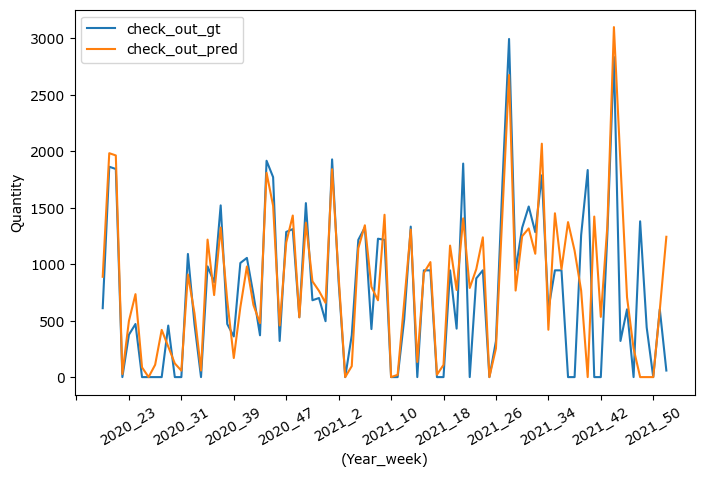

In [58]:
# 可視化結果-出庫量
index_num = get_date['Year'].astype('str') + '_' + get_date['week'].astype('str')  # index_num = Year_week (合併年/週)

plt.figure(figsize = (8,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))  # 設定x軸刻度間距 
plt.plot( index_num[seq_len+(predict_week-1):] , test_gt, label='check_out_gt') # test_gt[i:]
plt.plot( index_num[seq_len+(predict_week-1):] , test_pred, label='check_out_pred')

plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()
plt.show()

## 可視化-庫存量結果

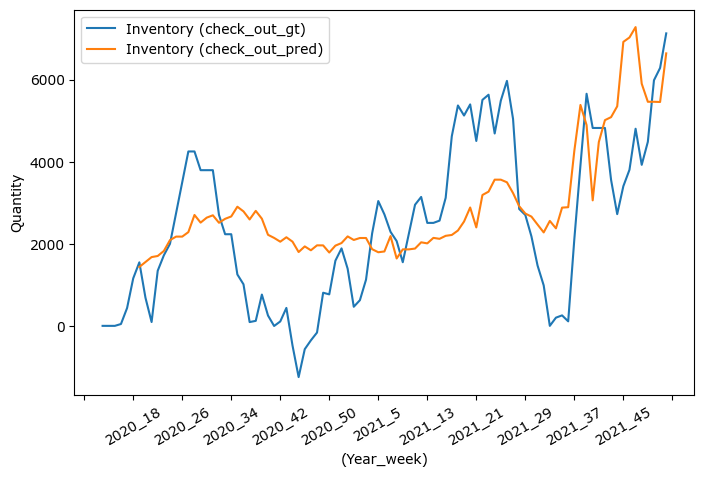

In [59]:
# 可視化結果-比較庫存量
index_num = get_date['Year'].astype('str') + '_' + get_date['week'].astype('str')  # index_num = Year_week (合併年/週)

plt.figure(figsize = (8,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))  # 設定x軸刻度間距 
plt.plot( index_num , inventory_gt, label='Inventory (check_out_gt)')
plt.plot( index_num[seq_len+(predict_week-1):] , inventory_pred, label='Inventory (check_out_pred)')

plt.xlabel("(Year_week)")
plt.ylabel("Quantity")
plt.xticks(rotation=30)
plt.legend()

plt.show()

## 匯出庫存量變化

In [60]:
output = pd.DataFrame()
inventory_gt = inventory_gt[seq_len+(predict_week-1):]
output['inventory_pred'] = pd.DataFrame(inventory_pred)
output['inventory_gt'] = pd.DataFrame(inventory_gt)
output_sub = output['inventory_pred'].sub(output['inventory_gt'])
output_sub

0     -112
1      870
2     1582
3      359
4      106
      ... 
82    1976
83     976
84    -524
85    -829
86    -487
Length: 87, dtype: int64

In [61]:
output_sub = output_sub.div(output['inventory_gt'])
output_sub

0     -0.072398
1      1.270073
2     17.010753
3      0.267312
4      0.061700
        ...    
82     0.503825
83     0.217760
84    -0.087596
85    -0.131964
86    -0.068360
Length: 87, dtype: float64

In [62]:
output['(-)有效降低: 庫存百分比'] = pd.DataFrame(output_sub)
output

,inventory_pred,inventory_gt,(-)有效降低: 庫存百分比
0,1435,1547,-0.072398
1,1555,685,1.270073
2,1675,93,17.010753
3,1702,1343,0.267312
4,1824,1718,0.061700
...,...,...,...
82,5898,3922,0.503825
83,5458,4482,0.217760
84,5458,5982,-0.087596
85,5453,6282,-0.131964


In [63]:
# 改成百分比
temp = output
temp = temp.applymap(lambda x: '%.2f%%' % (x*100))
output['(-)有效降低: 庫存百分比'] = temp['(-)有效降低: 庫存百分比']
output

,inventory_pred,inventory_gt,(-)有效降低: 庫存百分比
0,1435,1547,-7.24%
1,1555,685,127.01%
2,1675,93,1701.08%
3,1702,1343,26.73%
4,1824,1718,6.17%
...,...,...,...
82,5898,3922,50.38%
83,5458,4482,21.78%
84,5458,5982,-8.76%
85,5453,6282,-13.20%


In [64]:
# 加入時間
index_num_y = index_num[seq_len+(predict_week-1):]  # 日期從預測的第一週開始
index_num_y.reset_index(drop=True, inplace=True)
output['Year_Week'] = index_num_y
output = output.set_index(['Year_Week'])
output

,inventory_pred,inventory_gt,(-)有效降低: 庫存百分比
Year_Week,,,
2020_19,1435,1547,-7.24%
2020_20,1555,685,127.01%
2020_21,1675,93,1701.08%
2020_22,1702,1343,26.73%
2020_23,1824,1718,6.17%
...,...,...,...
2021_48,5898,3922,50.38%
2021_49,5458,4482,21.78%
2021_50,5458,5982,-8.76%


In [65]:
before_inv_num = (output['inventory_gt']<0).sum()
after_inv_num = (output['inventory_pred']<0).sum()
print('原先庫存不足之週數: ', before_inv_num)
print('預測後庫存不足之週數: ', after_inv_num)

原先庫存不足之週數:  6
預測後庫存不足之週數:  0


## 匯出建議入庫量 

In [66]:
Recommend = pd.DataFrame()
Recommend['Original_put_in'] = pd.DataFrame(put_in_gt)
Recommend['Recommended_put_in'] = pd.DataFrame(test_pred)
Recommend[Recommend<0] = 0
index_num_y = index_num[seq_len:]  # 日期從預測的第一週開始
index_num_y.reset_index(drop=True, inplace=True)
Recommend['Year_Week'] = index_num_y
Recommend = Recommend.set_index(['Year_Week'])
Recommend

,Original_put_in,Recommended_put_in
Year_Week,,
2020_18,1000,888.0
2020_19,1000,1982.0
2020_20,1000,1962.0
2020_21,1250,27.0
2020_22,1250,497.0
...,...,...
2021_48,500,0.0
2021_49,1000,0.0
2021_50,1500,595.0
